### WebGL online

In [1]:
# General imports
import os
import sys
import numpy as np
import json
import copy
import cortex
import matplotlib.pyplot as plt

# Personal imports
sys.path.append("{}/../../../../utils".format(os.getcwd()))
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap

# Inputs
main_dir = '/Users/martinszinte/disks/meso_S/data/'
project_dir = 'amblyo_prf'
subject = 'sub-02'
save_svg = False

# Define analysis parameters
with open('../../../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
if subject == 'sub-170k': formats = ['170k']
else: formats = analysis_info['formats']
extensions = analysis_info['extensions']
prf_task_name = analysis_info['prf_task_name']
alpha_range = analysis_info["alpha_range"]
tasks = analysis_info['task_names']

# Maps settings
cmap_corr = 'BuBkRd'

# Index
slope_idx, intercept_idx, rvalue_idx, pvalue_idx, stderr_idx, \
    trs_idx, corr_pvalue_5pt_idx, corr_pvalue_1pt_idx = 0, 1, 2, 3, 4, 5, 6, 7

# Plot scales
corr_scale = [-1, 1]

# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)


prf
prf_run_corr


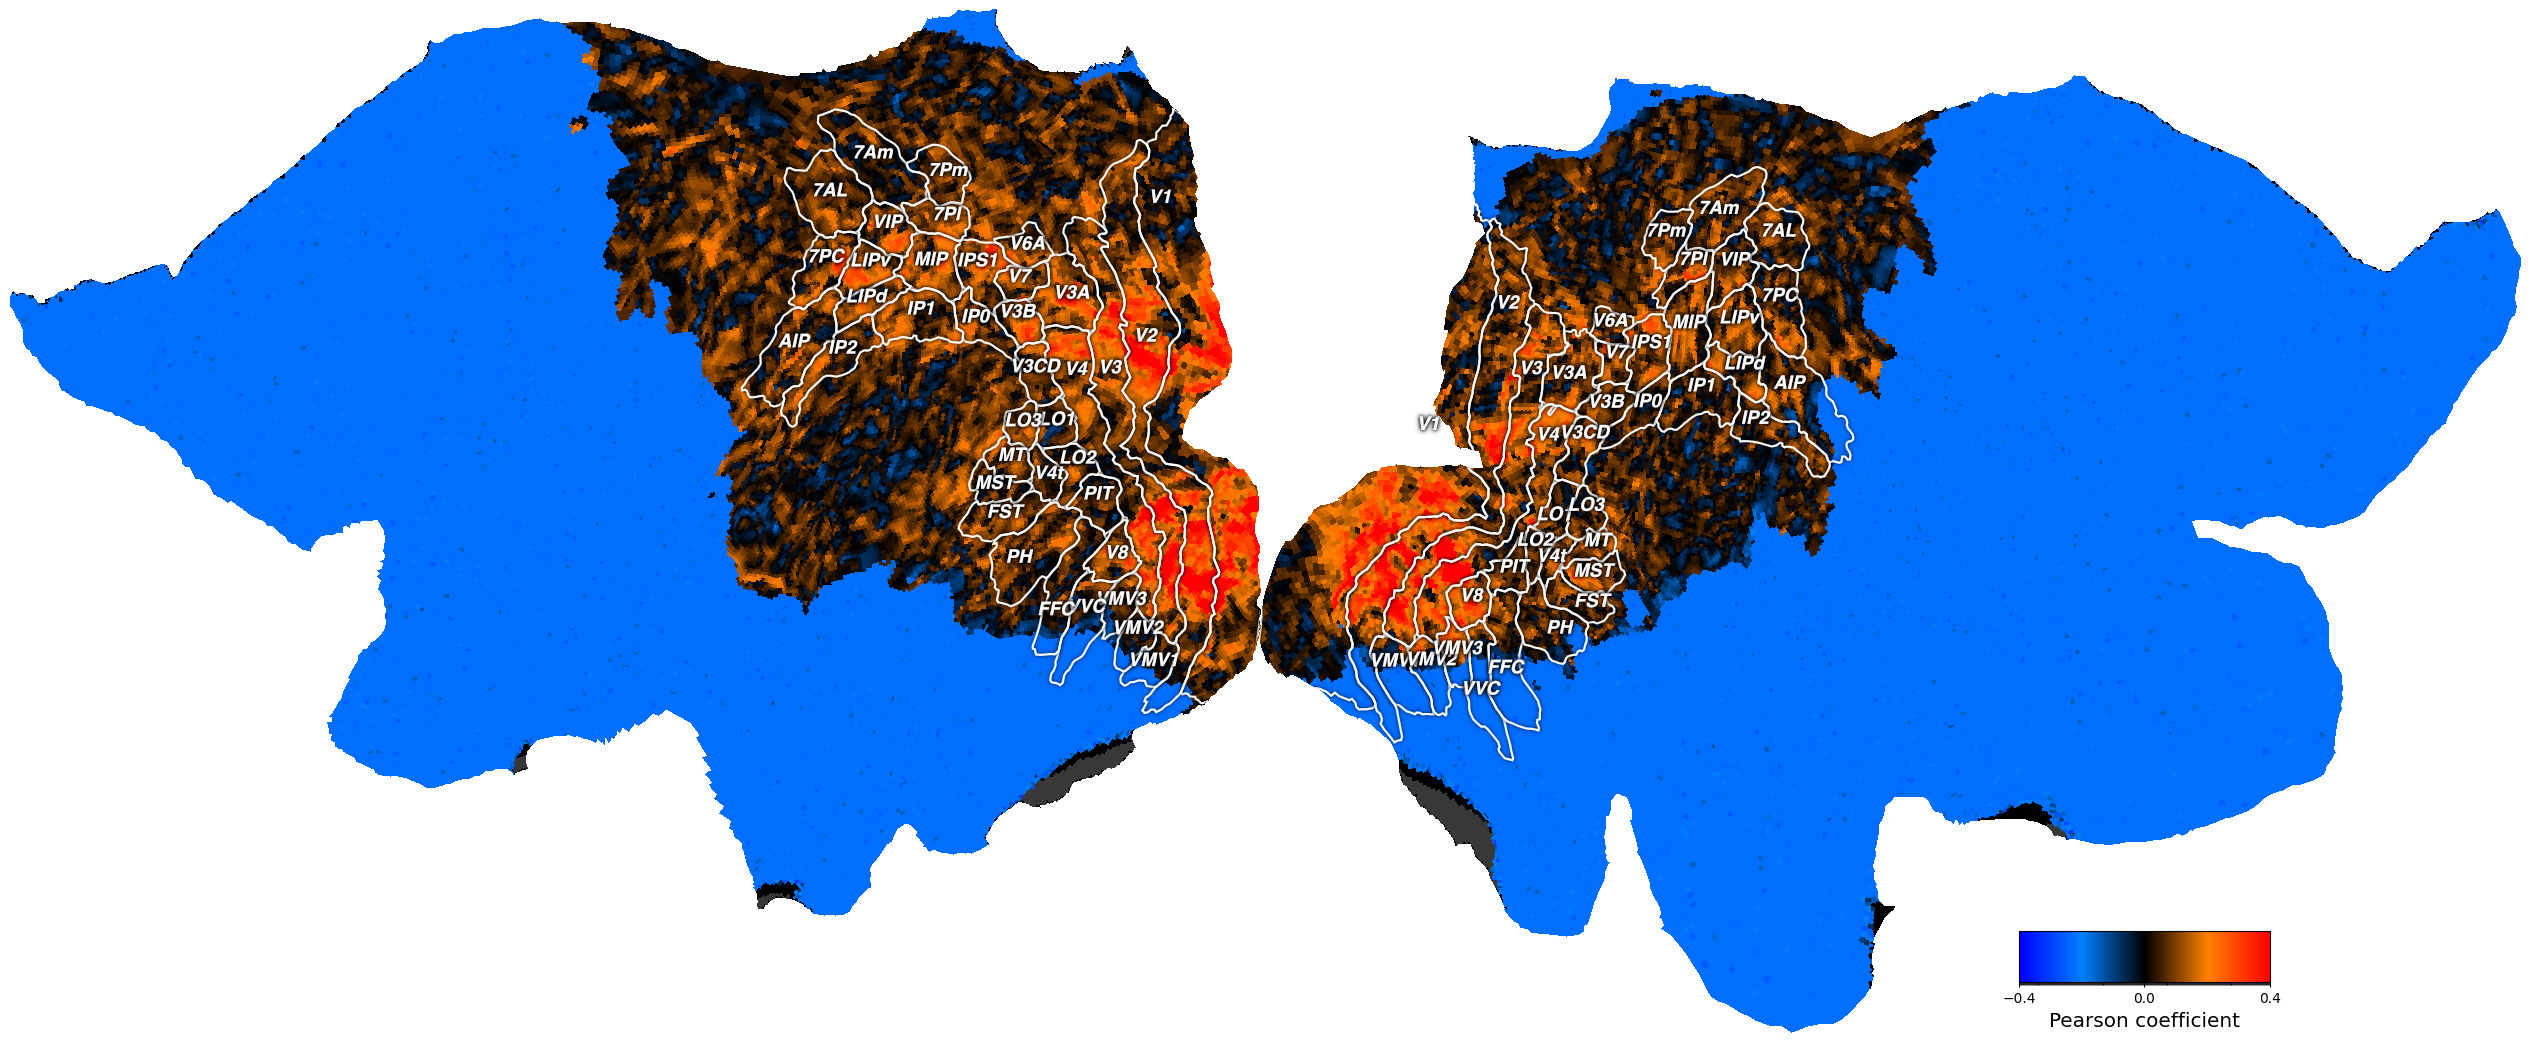

In [18]:
# Create flatmaps
formats = ['170k']

for format_, pycortex_subject in zip(formats, ['sub-170k', subject]):
    corr_dir = "{}/{}/derivatives/pp_data/{}/{}/corr/fmriprep_dct_corr".format(main_dir, project_dir, subject, format_)
    flatmaps_dir = '{}/{}/derivatives/pp_data/{}/{}/corr/pycortex/flatmaps_inter-run-corr'.format(main_dir, project_dir, subject, format_)
    datasets_dir = '{}/{}/derivatives/pp_data/{}/{}/corr/pycortex/datasets_inter-run-corr'.format(main_dir, project_dir, subject, format_)

    os.makedirs(flatmaps_dir, exist_ok=True)
    os.makedirs(datasets_dir, exist_ok=True)

    for task in tasks : 
        print(task)
        
        if format_ == 'fsnative':
            corr_fn_L = "{}/{}_task-{}_hemi-L_fmriprep_dct_corr_bold.func.gii".format(corr_dir, subject, task)
            corr_fn_R = "{}/{}_task-{}_hemi-R_fmriprep_dct_corr_bold.func.gii".format(corr_dir, subject, task)
            results = load_surface_pycortex(L_fn=corr_fn_L, R_fn=corr_fn_R)
        elif format_ == '170k':
            cor_fn = '{}/{}_task-{}_fmriprep_dct_corr_bold.dtseries.nii'.format(corr_dir, subject, task)
            results = load_surface_pycortex(brain_fn=cor_fn)
            if subject == 'sub-170k':
                save_svg = save_svg
            else: 
                save_svg = False
        corr_mat = results['data_concat']
        maps_names = []        
        
        # Correlation uncorrected
        corr_mat_uncorrected = corr_mat[rvalue_idx, :]
        # corr_mat_uncorrected[np.isnan(corr_mat_uncorrected)]=0

        # Compute alpha
        alpha_uncorrected = np.abs(corr_mat_uncorrected)
        alpha_uncorrected = (alpha_uncorrected - alpha_range[0]) / (alpha_range[1] - alpha_range[0])
        alpha_uncorrected[alpha_uncorrected>1]=1
        # alpha_uncorrected[np.isnan(alpha_uncorrected)]=0
        
        # correlation uncorrected
        param_run_corr = {'data': corr_mat_uncorrected, 
                          'alpha': alpha_uncorrected*0+1,
                          'cmap': cmap_corr,
                          'vmin': -0.4, 
                          'vmax': 0.4,
                          'cbar': 'discrete', 
                          'cortex_type': 'VertexRGB', 
                          'description': 'Inter-run correlation (uncorrected): task-{}'.format(task), 
                          'curv_brightness': 0.1, 
                          'curv_contrast': 0.25, 
                          'add_roi': save_svg, 
                          'cbar_label': 'Pearson coefficient',
                          'with_labels': True}
        maps_names.append('run_corr')

#         # Correlation corrected mat
#         corr_mat_corrected = copy.copy(corr_mat)
#         corr_mat_corrected_th = corr_mat_corrected
#         if analysis_info['stats_th'] == 0.05: stats_th_down = corr_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
#         elif analysis_info['stats_th'] == 0.01: stats_th_down = corr_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
#         corr_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it
#         corr_mat_corrected = corr_mat_corrected[rvalue_idx, :]

#         # Compute alpha
#         alpha_corrected = np.abs(corr_mat_corrected)
#         alpha_corrected = (alpha_corrected - alpha_range[0]) / (alpha_range[1] - alpha_range[0])
#         alpha_corrected[alpha_corrected>1]=1
    
#         # correlation corrected
#         param_run_corr_stats = {'data': corr_mat_corrected, 
#                               'alpha': alpha_corrected,
#                               'cmap': cmap_corr ,
#                               'vmin': corr_scale[0], 
#                               'vmax': corr_scale[1], 
#                               'cbar': 'discrete', 
#                               'cortex_type': 'VertexRGB', 
#                               'description': 'Inter-run correlation (corrected): task-{}'.format(task),
#                               'curv_brightness': 0.1, 
#                               'curv_contrast': 0.25, 
#                               'add_roi': save_svg, 
#                               'cbar_label': 'Pearson coefficient',
#                               'with_labels': True}
#         maps_names.append('run_corr_stats')

        # draw flatmaps
        volumes = {}
        for maps_name in maps_names:
            
            # create flatmap
            roi_name = '{}_{}'.format(task, maps_name)
            roi_param = {'subject': pycortex_subject, 
                         'roi_name': roi_name}
            print(roi_name)
            exec('param_{}.update(roi_param)'.format(maps_name))
            exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name=maps_name))

In [4]:
# Webgl for inflated brain pictures
handle = cortex.webgl.show(data=volume_run_corr, 
                           recache=False,
                          )

Started server on port 48332


In [ ]:
# # Webgl for inflated brain pictures
# handle = cortex.webgl.show(data=braindata, 
#                            recache=False,
#                            types=('inflated',)
#                           )

Started server on port 28763
Stopping server


In [5]:
np.unique(corr_mat_uncorrected)

array([-0.33170202, -0.31952543, -0.31431094, ...,  0.57932833,
        0.58590615,  0.61970366])

In [6]:
np.unique(alpha_uncorrected)

array([0.00000000e+00, 4.71182351e-05, 6.81060133e-05, ...,
       9.99647145e-01, 9.99906303e-01, 1.00000000e+00])

In [16]:
np.sum(np.isnan(corr_mat_uncorrected))

1230

In [20]:
corr_mat_uncorrected[47971]

-0.2254707651009891

Stopping server
